In [1]:
# %%
import sys
sys.path.append('..')
# sys.path.append('/system/user/beck/pwbeck/projects/regularization/ml_utilities')
from pathlib import Path
from typing import Union
from ml_utilities.torch_models.base_model import BaseModel
from ml_utilities.torch_models import get_model_class
from omegaconf import OmegaConf

from erank.utils import load_directions_matrix_from_task_sweep
import matplotlib.pyplot as plt    


/system/apps/userenv/beck/erank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
run_path = '/system/user/beck/pwbeck/projects/regularization/erank/outputs/f_mnist-same_init-taskidxXXX_230622_162800/outputs/f_mnist-same_init-taskidx0-seed0_230622_162819'

if isinstance(run_path, str):
    run_path = Path(run_path)
# load config
loaded_config = OmegaConf.load(run_path/'.hydra'/'config.yaml')
config = loaded_config.config
# get model class
model_name = config.model.name
model_class = get_model_class(model_name)
# get best epoch
best_epoch_file = run_path / 'best_epoch.txt'
assert best_epoch_file.exists(), 'No best epoch file found.'

In [3]:
with best_epoch_file.open() as f:
    t = f.read()
    print(t)

12


In [4]:
run_path.stem

'f_mnist-same_init-taskidx0-seed0_230622_162819'

In [5]:
p = '/system/user/beck/pwbeck/projects/regularization/erank/outputs/f_mnist-2.0-taskidxXXX_260622_110634/outputs'
dir_matrix = load_directions_matrix_from_task_sweep(p)
dir_matrix.requires_grad_(True)

Loading /system/user/beck/pwbeck/projects/regularization/erank/outputs/f_mnist-2.0-taskidxXXX_260622_110634/outputs/f_mnist-2.0-taskidx3-seed0_260622_110648: 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


tensor([[-0.0005, -0.0005, -0.0004,  ..., -0.0032,  0.0077, -0.0123],
        [-0.0044, -0.0045, -0.0043,  ..., -0.0023,  0.0065, -0.0126],
        [-0.0035, -0.0035, -0.0034,  ...,  0.0005,  0.0075, -0.0096],
        ...,
        [-0.0034, -0.0034, -0.0034,  ..., -0.0009,  0.0030, -0.0107],
        [-0.0011, -0.0011, -0.0012,  ..., -0.0041,  0.0075, -0.0082],
        [-0.0046, -0.0046, -0.0050,  ..., -0.0013,  0.0027, -0.0132]],
       device='cuda:0', requires_grad=True)

In [6]:
dir_matrix.shape, dir_matrix.device, dir_matrix.requires_grad

(torch.Size([10, 669706]), device(type='cuda', index=0), True)

In [7]:
d = dict(a=1,b=2,c=3)
for x in d:
    print(x)

a
b
c


In [8]:
import torch
t = torch.tensor(0.0)

In [9]:
t.dtype, t.device

(torch.float32, device(type='cpu'))

In [10]:
def erank(matrix_A: torch.Tensor, center_matrix_A: bool=False) -> torch.Tensor:
        """Calculates the effective rank of a matrix.

        Args:
            matrix_A (torch.Tensor): Matrix of shape m x n. 
            center_matrix_A (bool): Center the matrix 

        Returns:
            torch.Tensor: Effective rank of matrix_A
        """
        assert matrix_A.ndim == 2
        _, s, _ = torch.pca_lowrank(matrix_A, center=center_matrix_A, niter=1, q=min(matrix_A.shape[0], matrix_A.shape[1]))
        s = torch.square(s) / (s.shape[0] - 1)

        # normalizes input s -> scale independent!
        return torch.exp(torch.distributions.Categorical(s).entropy())

In [11]:
er = erank(dir_matrix)

In [12]:
er

tensor(6.0191, device='cuda:0', grad_fn=<ExpBackward>)

In [13]:
# er.backward()

## normalize directions

In [14]:
norm_dir_matrix = dir_matrix / torch.linalg.norm(dir_matrix, ord=2, dim=1, keepdim=True)

In [15]:
torch.linalg.norm(dir_matrix, ord=2, dim=1, keepdim=True), torch.linalg.norm(norm_dir_matrix, ord=2, dim=1, keepdim=True)

(tensor([[11.7831],
         [ 9.9273],
         [12.0242],
         [11.0410],
         [11.1749],
         [11.7312],
         [10.3839],
         [10.7438],
         [12.8635],
         [11.3913]], device='cuda:0', grad_fn=<CopyBackwards>),
 tensor([[1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000],
         [1.0000]], device='cuda:0', grad_fn=<CopyBackwards>))

In [16]:
erank(norm_dir_matrix)

tensor(6.0408, device='cuda:0', grad_fn=<ExpBackward>)

## do we need to normalize dir matrix?

In [17]:
delta = torch.zeros(size=(1,dir_matrix.shape[1])).to(dir_matrix)
delta[0] = 10
matrix1 = torch.cat([delta, dir_matrix], dim=0)
erank(matrix1)

tensor(1.0003, device='cuda:0', grad_fn=<ExpBackward>)

In [18]:
delta = torch.zeros(size=(1,dir_matrix.shape[1])).to(dir_matrix)
delta[0] = 1e-3
matrix1 = torch.cat([delta, dir_matrix], dim=0)
erank(matrix1)

tensor(6.0403, device='cuda:0', grad_fn=<ExpBackward>)

In [19]:
# make plot erank vs. appended vector norm
# def erank_vs_update_step_norm(dir_matrix, vals=20)
erank_vals = []
vec_norms = torch.logspace(-4, 1, 20)
for n in vec_norms:
    delta = torch.zeros(size=(1,dir_matrix.shape[1])).to(dir_matrix)
    delta[0] = n
    matrix1 = torch.cat([delta, dir_matrix], dim=0)
    erank_vals.append(erank(matrix1).item())

Text(0.5, 1.0, 'erank of unnormalized matrix')

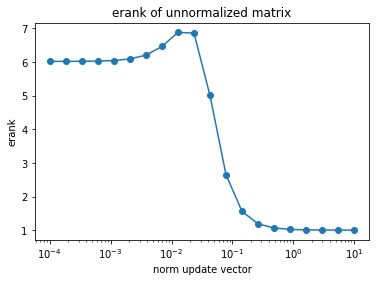

In [20]:
plt.plot(vec_norms, erank_vals, 'o-')
plt.xscale('log')
plt.ylabel('erank')
plt.xlabel('norm update vector')
plt.title('erank of unnormalized matrix')

In [21]:
# yes erank is dependent on norms of row and column vectors

In [22]:
# make same plot of normalized matrix

erank_vals = []
vec_norms = torch.logspace(-4, 1, 20)
for n in vec_norms:
    delta = torch.zeros(size=(1,dir_matrix.shape[1])).to(dir_matrix)
    delta[0] = n
    matrix1 = torch.cat([delta, dir_matrix], dim=0)
    # normalize matrix
    matrix1 = matrix1 / torch.linalg.norm(matrix1, ord=2, dim=1, keepdim=True)
    erank_vals.append(erank(matrix1).item())

Text(0.5, 1.0, 'erank of normalized matrix')

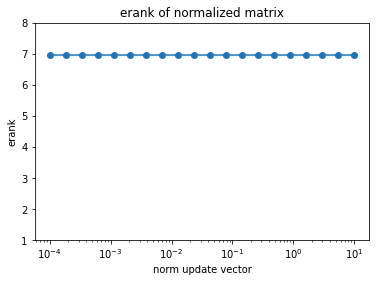

In [27]:
plt.plot(vec_norms, erank_vals, 'o-')
plt.xscale('log')
plt.ylabel('erank')
plt.xlabel('norm update vector')
plt.ylim(1,8)
plt.title('erank of normalized matrix')

In [24]:
erank_vals

[6.955451011657715,
 6.955439567565918,
 6.955437660217285,
 6.955447673797607,
 6.955437660217285,
 6.955438137054443,
 6.955419063568115,
 6.955432415008545,
 6.955447673797607,
 6.955459117889404,
 6.955445766448975,
 6.955447673797607,
 6.95543098449707,
 6.955449104309082,
 6.955447673797607,
 6.955435752868652,
 6.955446720123291,
 6.955439567565918,
 6.955442428588867,
 6.9554290771484375]

## try different queues

In [25]:
from queue import Queue

queue = Queue(2)

queue.put(0)
queue.put(2)

In [26]:
from collections import deque

q = deque(maxlen=2)
q.append(0)
print(len(q))
q.append(1)
q

1


deque([0, 1])